## Importing libraries

In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import mpl_scatter_density as mpl

In [26]:
#import sys
#!{sys.executable} -m pip install mpl_scatter_density

  Using cached mpl_scatter_density-0.7-py3-none-any.whl (655 kB)
  Using cached fast_histogram-0.11-cp36-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (52 kB)


## Reading the data

In [48]:
bhbh = pd.read_csv('../Data/BHBH.csv')
bhbh['q'] = np.where(bhbh['Mass_1_out']>bhbh['Mass_0_out'], bhbh['Mass_0_out']/bhbh['Mass_1_out'], bhbh['Mass_1_out']/bhbh['Mass_0_out'] )
bhbh['q_label']=(bhbh['q'].round(2)*100).astype('int')
bhbh.head()

bhbh = bhbh.sample(frac=1)

## Preparing the data for xgboost

In [49]:
#bhbh[bhbh['q'].round(2)>=1]

In [50]:
data = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][1:60000]
label = bhbh[['q_label']][1:60000]
dtrain = xgb.DMatrix(data, label=label)

In [51]:
data = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][60000:70000]
label = bhbh[['q_label']][60000:70000]
dtest = xgb.DMatrix(data, label=label)

## Boost Parameters

In [52]:
param = {'max_depth': 6, 'eta': 0.3, 'objective': 'multi:softprob'}
#param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class']=101
#param['eval_metric'] = ['auc', 'ams@0']

evallist = [(dtrain, 'train'), (dtest, 'eval')]

## Training

In [53]:
param

{'max_depth': 6,
 'eta': 0.3,
 'objective': 'multi:softprob',
 'eval_metric': 'auc',
 'num_class': 101}

In [54]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[11:45:00] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:45:00] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[0]	train-auc:nan	eval-auc:nan
[11:45:07] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:45:07] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[1]	train-auc:nan	eval-auc:nan
[11:45:14] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:45:14] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[2]	train-auc:nan	eval-auc:nan
[11:45:21] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:45:21] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[3]	train-auc:nan	e

## Saving the model

In [55]:
bst.save_model('0001.model')

## Loading a saved model

In [56]:
#bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('0001.model')  # load data

## Predictions of the model

In [57]:
ypred = bst.predict(dtest)

In [58]:
prediction = pd.DataFrame(ypred)
a=np.array(prediction)
a.shape

(10000, 101)

In [59]:
example = np.array(prediction)[0,:]
example

array([0.0022075 , 0.0022075 , 0.0022075 , 0.0022075 , 0.0022075 ,
       0.0022075 , 0.0022075 , 0.00222044, 0.0022075 , 0.0022075 ,
       0.00222044, 0.00225932, 0.00225932, 0.00222554, 0.00221395,
       0.00222116, 0.0022305 , 0.00221241, 0.00287277, 0.00221257,
       0.00306121, 0.00223858, 0.00221808, 0.00231784, 0.00221941,
       0.00241235, 0.00222812, 0.00222824, 0.00298627, 0.0022075 ,
       0.00687949, 0.00389674, 0.02340336, 0.00442497, 0.00608611,
       0.00730404, 0.01035902, 0.02635426, 0.00828691, 0.03687954,
       0.02116427, 0.01008138, 0.02409946, 0.02564892, 0.02088486,
       0.01313629, 0.01983889, 0.01821302, 0.01845134, 0.02778262,
       0.02104545, 0.02179658, 0.01845079, 0.0159572 , 0.02297638,
       0.01695715, 0.07208665, 0.01896539, 0.0022075 , 0.01863828,
       0.01830119, 0.01487605, 0.01433572, 0.01508177, 0.01719682,
       0.01530702, 0.00993704, 0.01026472, 0.01145085, 0.01178605,
       0.00995876, 0.01154656, 0.00987217, 0.00704709, 0.02108

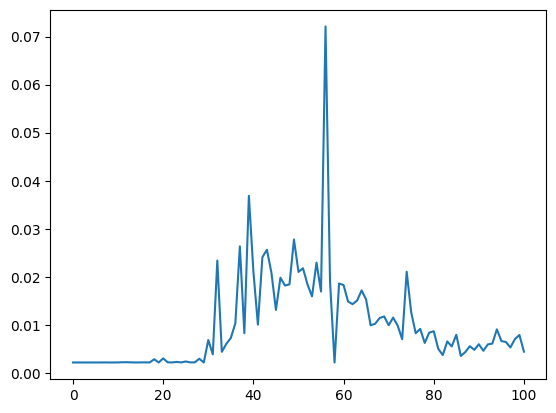

In [60]:
x = np.arange(0, 101)
plt.plot(x, example)

In [61]:
bhbh['q_label'][60001]

90

In [62]:
prediction_tot = np.argmax(a, axis=1)
prediction_tot.shape

(10000,)

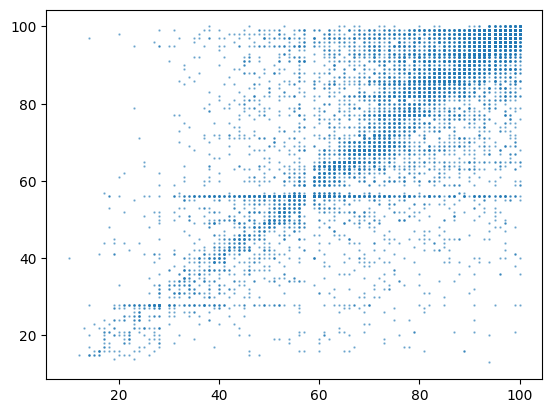

In [63]:
plt.scatter(bhbh['q_label'][60000:70000], prediction_tot, s=0.5, alpha=0.5)

/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


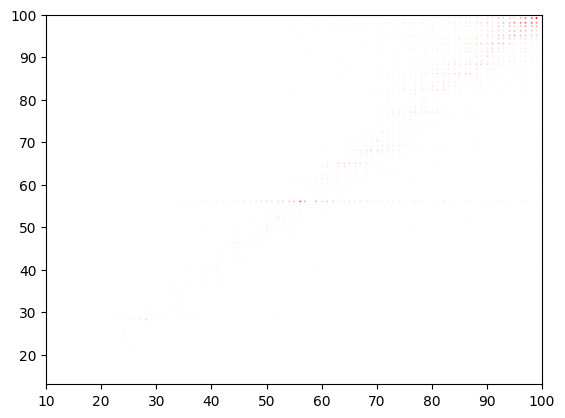

In [64]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1,projection='scatter_density')
ax.scatter_density(bhbh['q_label'][60000:70000], prediction_tot, color='red', vmin=0, vmax=100)

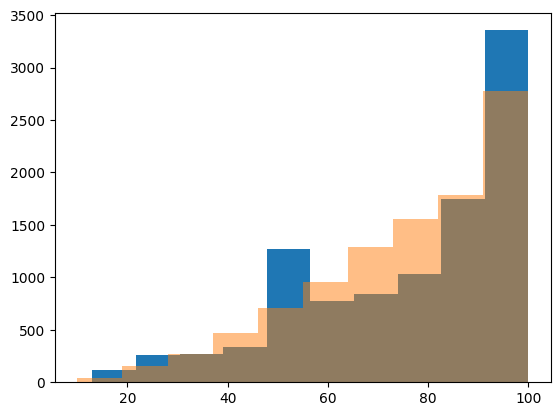

In [69]:
plt.hist(prediction_tot);
plt.hist(bhbh['q_label'][60000:70000], alpha=0.5);